<a href="https://colab.research.google.com/github/Kennenzz/predict-employee-attrition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**XÂY DỰNG MÔ HÌNH DỰ ĐOÁN NGUY CƠ NGHỈ VIỆC CỦA NHÂN VIÊN**
---

#Import các thư viện sẽ sử dụng trong đồ án bao gồm:
*   **Pandas**
*   **Numpy**
*   **Matplotlib**
*   **Seaborn**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

---
#Đọc file dataset có được từ trang web *Kaggle.com*

In [33]:
try:
    df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    display(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dataset trong dữ liệu folder")
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


---
#Mô tả tổng quan về dataset

In [34]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 35)

#Tổng quan:
Dataset gồm 35 cột và 1470 dòng dữ liệu.

---
# Phân loại các biến trong dataset

In [35]:
# cần run file từ đầu đến cuối
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

print("Biến số:")
display(numerical_cols)

print("\nBiến phân loại:")
display(categorical_cols)

Biến số:


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


Biến phân loại:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

---
#**Tiền xử lý dữ liệu**
1.   Xử lý dữ liệu thiếu

In [36]:
df.isnull().sum()


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

**Không có dữ liệu thiếu trong dataset**

2.   Xử lý dữ liệu dư thừa, dữ liệu nhiễu (không liên quan)

In [37]:
df.drop(columns=['Over18', 'EmployeeNumber', 'EmployeeCount','StandardHours'], axis =1, inplace= True)

In [38]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 31)

Qua quan sát dữ liệu thì có thể thấy các cột dữ liệu không cần thiết như sau:
*   **Over18** tất cả nhân viên đều đã trên 18 tuổi
*   **EmployeeCount** luôn có giá trị là 1
*   **EmployeeNumber** luôn có giá trị khác nhau như việc nhân viên có mã nhân viên
*   **StandardHours** luôn có giá trị là 80

3.   Xử lý mã hóa biến phân loại

In [39]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 31)

In [40]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable 'Attrition'
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical columns (excluding 'Attrition' as it's already encoded)
categorical_cols = df.select_dtypes(include='object').columns

# Apply encoding to the remaining categorical columns
for col in categorical_cols:
    if df[col].nunique() == 2:
        # Apply Label Encoding for binary columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        # Apply One-Hot Encoding for columns with more than two unique values
        df = pd.get_dummies(df, columns=[col], drop_first=True)

display(df.head())

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,2,0,94,3,2,...,False,False,False,False,False,False,True,False,False,True
1,49,0,279,8,1,3,1,61,2,2,...,False,False,False,False,False,True,False,False,True,False
2,37,1,1373,2,2,4,1,92,2,1,...,False,True,False,False,False,False,False,False,False,True
3,33,0,1392,3,4,4,0,56,3,1,...,False,False,False,False,False,True,False,False,True,False
4,27,0,591,2,1,1,1,40,3,1,...,False,True,False,False,False,False,False,False,True,False


---
#**KHAI PHÁ DỮ LIỆU EDA**


Số lượng nhân viên nghỉ việc và không nghỉ việc:


Attrition
0    1233
1     237
Name: count, dtype: int64

C:\Users\kax20\AppData\Local\Temp\ipykernel_5632\3485626961.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Attrition', palette='viridis')


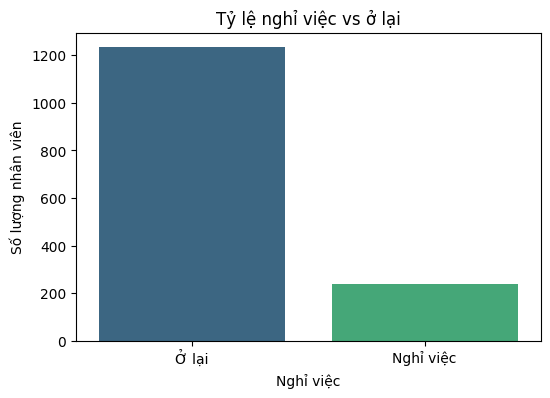


Phần trăm nhân viên nghỉ việc: 16.12%


In [41]:
# 1. Count the number of employees who stayed (0) and left (1)
attrition_counts = df['Attrition'].value_counts()
print("Số lượng nhân viên nghỉ việc và không nghỉ việc:")
display(attrition_counts)

# 2. Visualize the distribution using a countplot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Attrition', palette='viridis')
plt.title('Tỷ lệ nghỉ việc vs ở lại')
plt.xticks([0, 1], ['Ở lại', 'Nghỉ việc'])
plt.xlabel('Nghỉ việc')
plt.ylabel('Số lượng nhân viên')
plt.show()

# 3. Display the percentage of attrition
attrition_percentage = (attrition_counts[1] / len(df)) * 100
print(f"\nPhần trăm nhân viên nghỉ việc: {attrition_percentage:.2f}%")

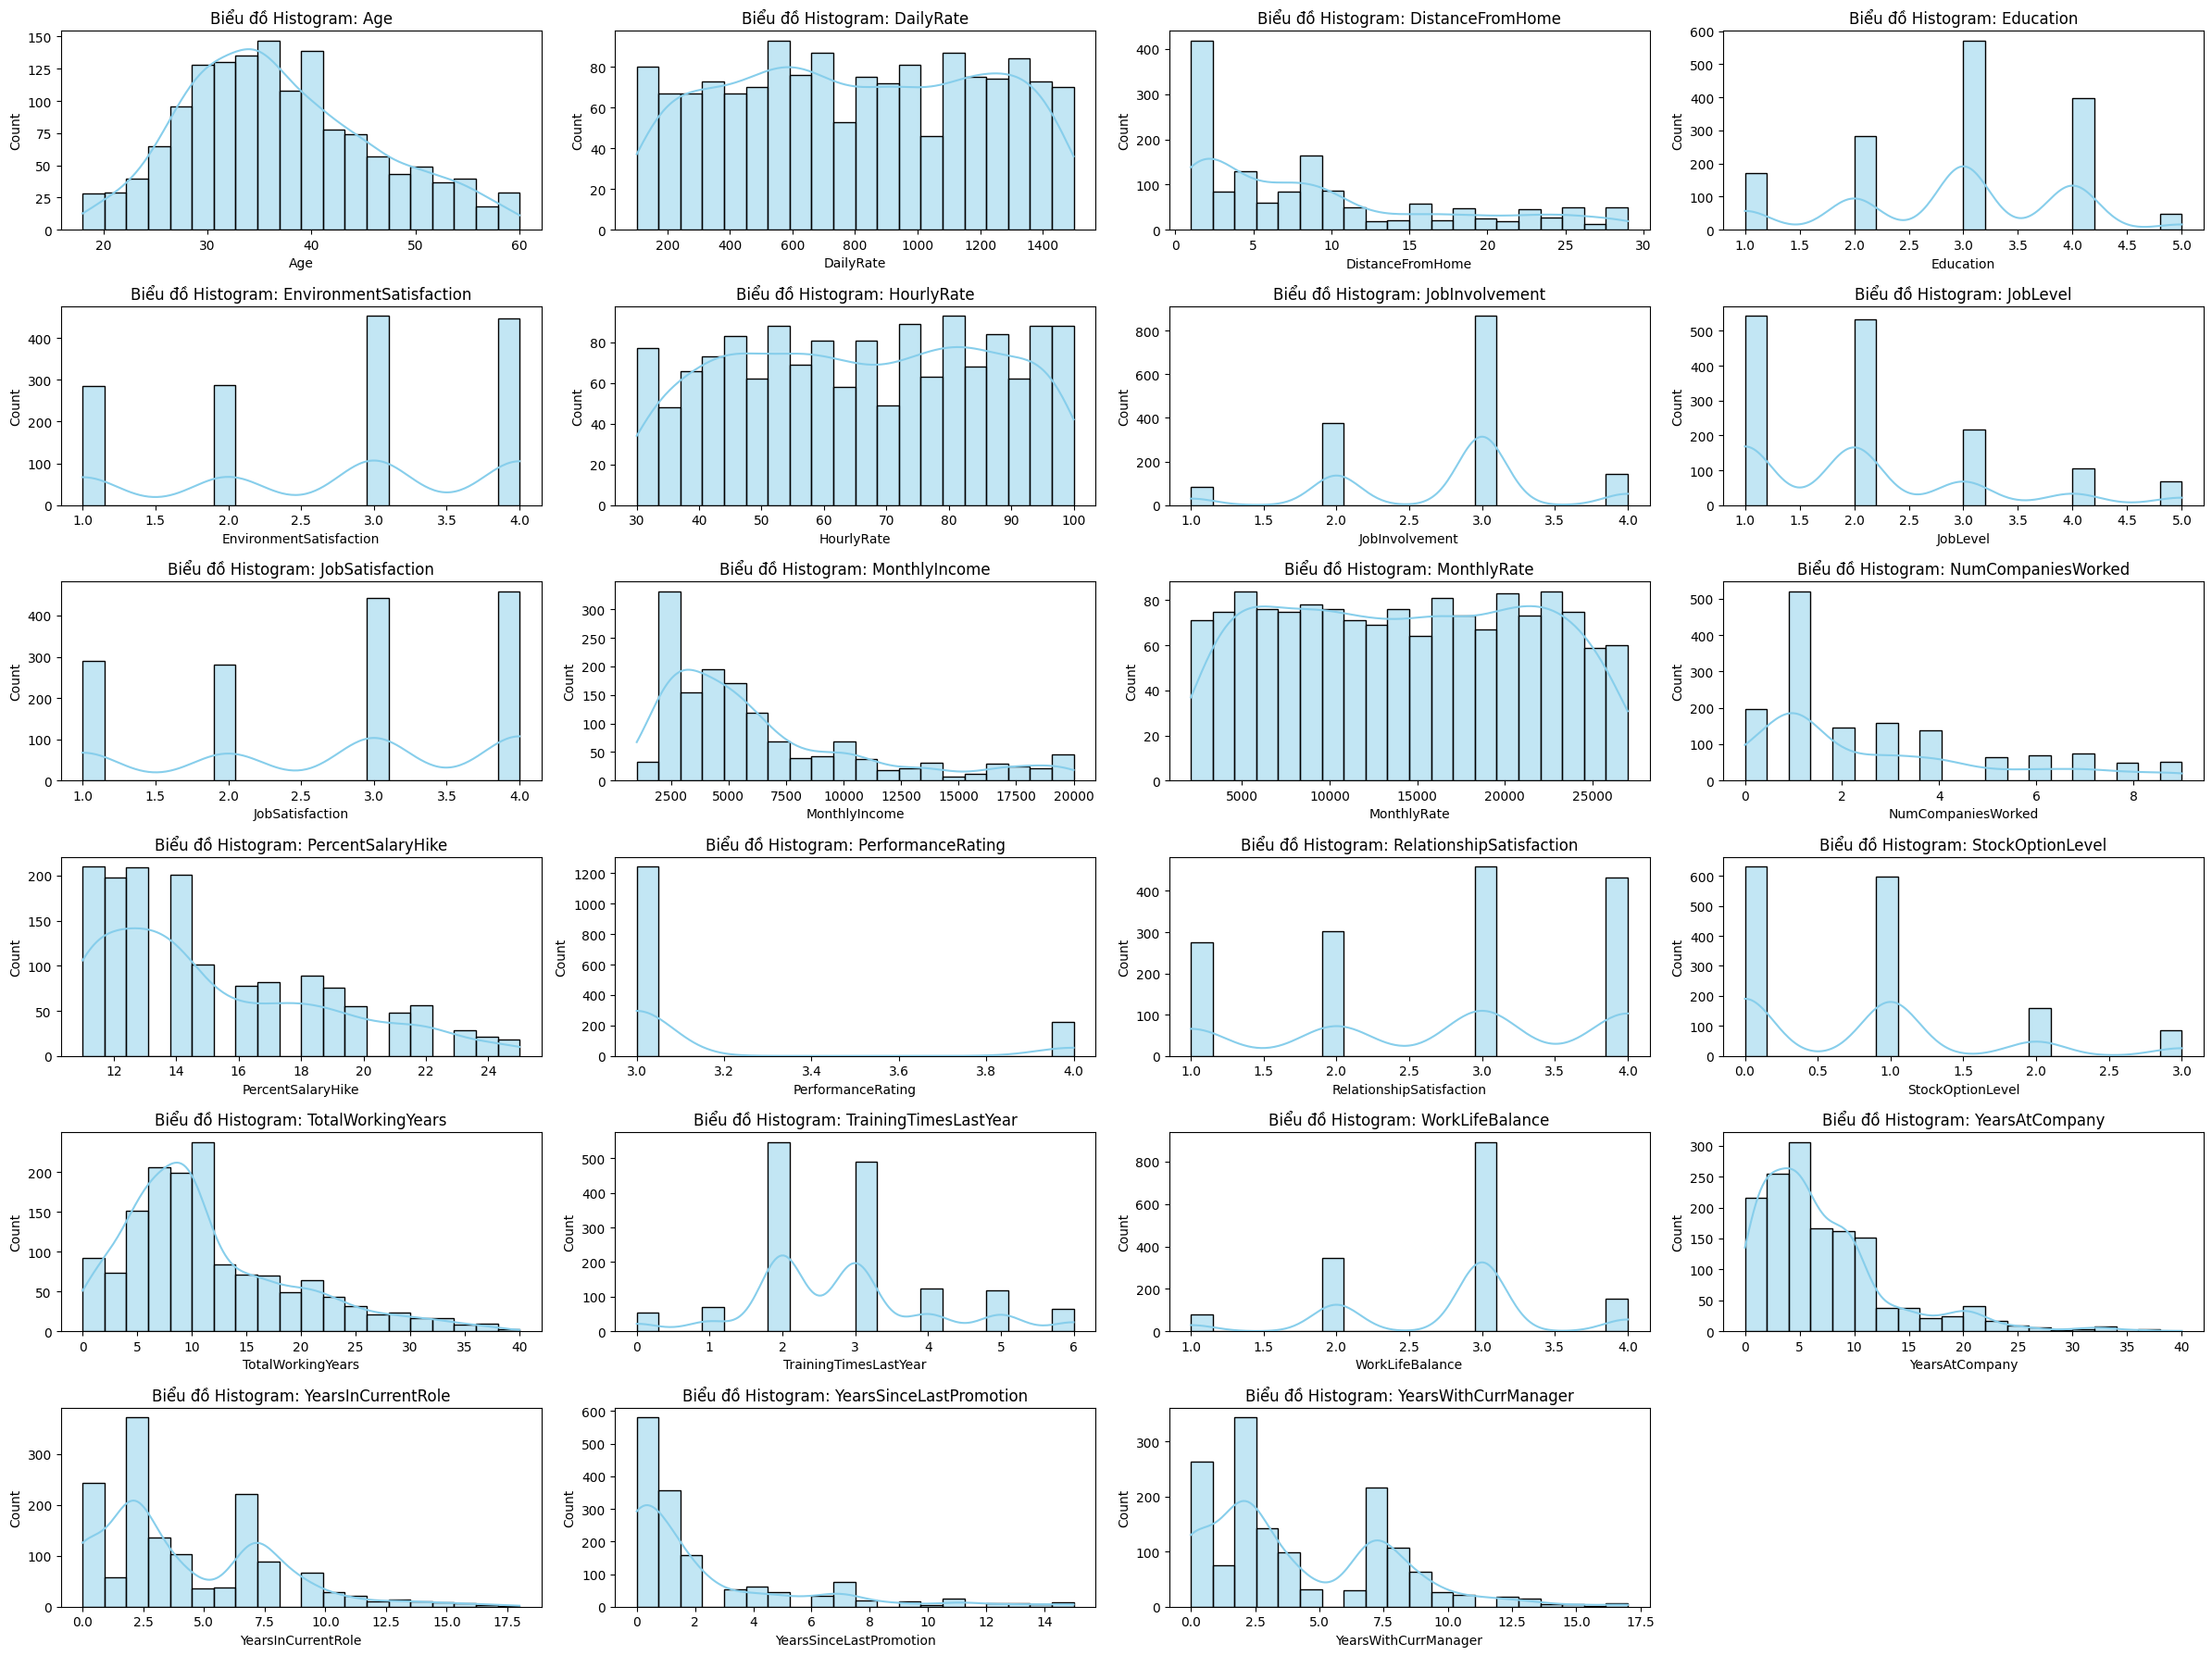

C:\Users\kax20\AppData\Local\Temp\ipykernel_5632\840611873.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')
C:\Users\kax20\AppData\Local\Temp\ipykernel_5632\840611873.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')
C:\Users\kax20\AppData\Local\Temp\ipykernel_5632\840611873.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')
C:\Users\kax20\AppData\Local\Temp\ipykernel_5632\840611873.py:14: FutureWarning: 

Passing `palette`

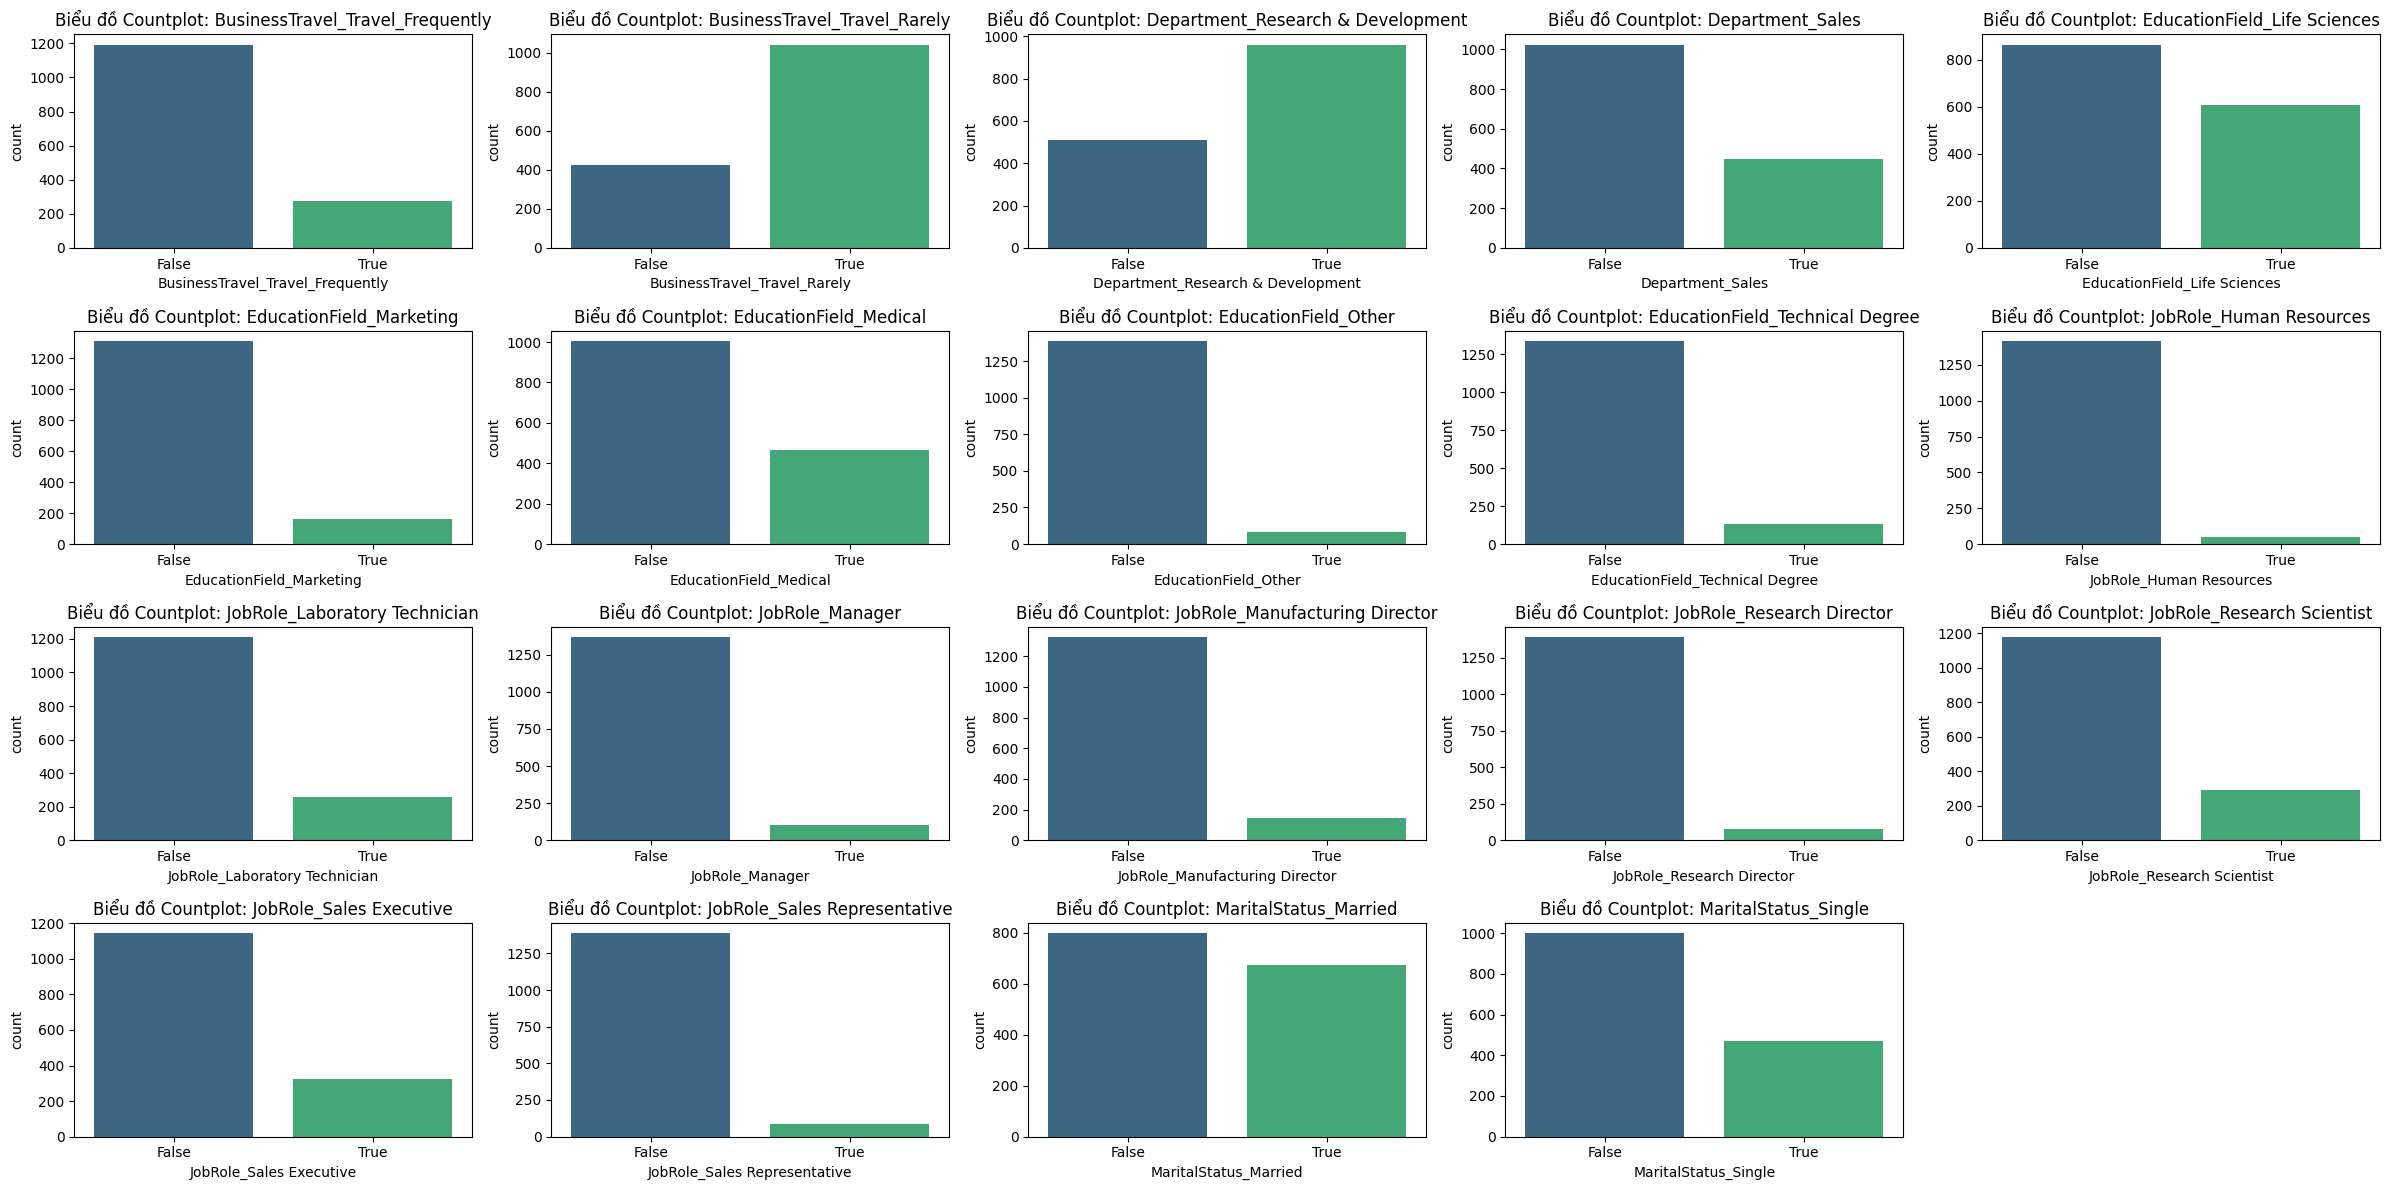

In [42]:
# Vẽ histogram cho các biến số
plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Biểu đồ Histogram: {col}')
plt.tight_layout()
plt.show()

# Vẽ countplot cho các biến phân loại (chỉ vẽ cho các biến đã được mã hóa nhị phân)
plt.figure(figsize=(24, 12))
for i, col in enumerate(df.columns[df.dtypes == 'bool']):
    plt.subplot(4, 5, i + 1)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Biểu đồ Countplot: {col}')
plt.tight_layout()
plt.show()

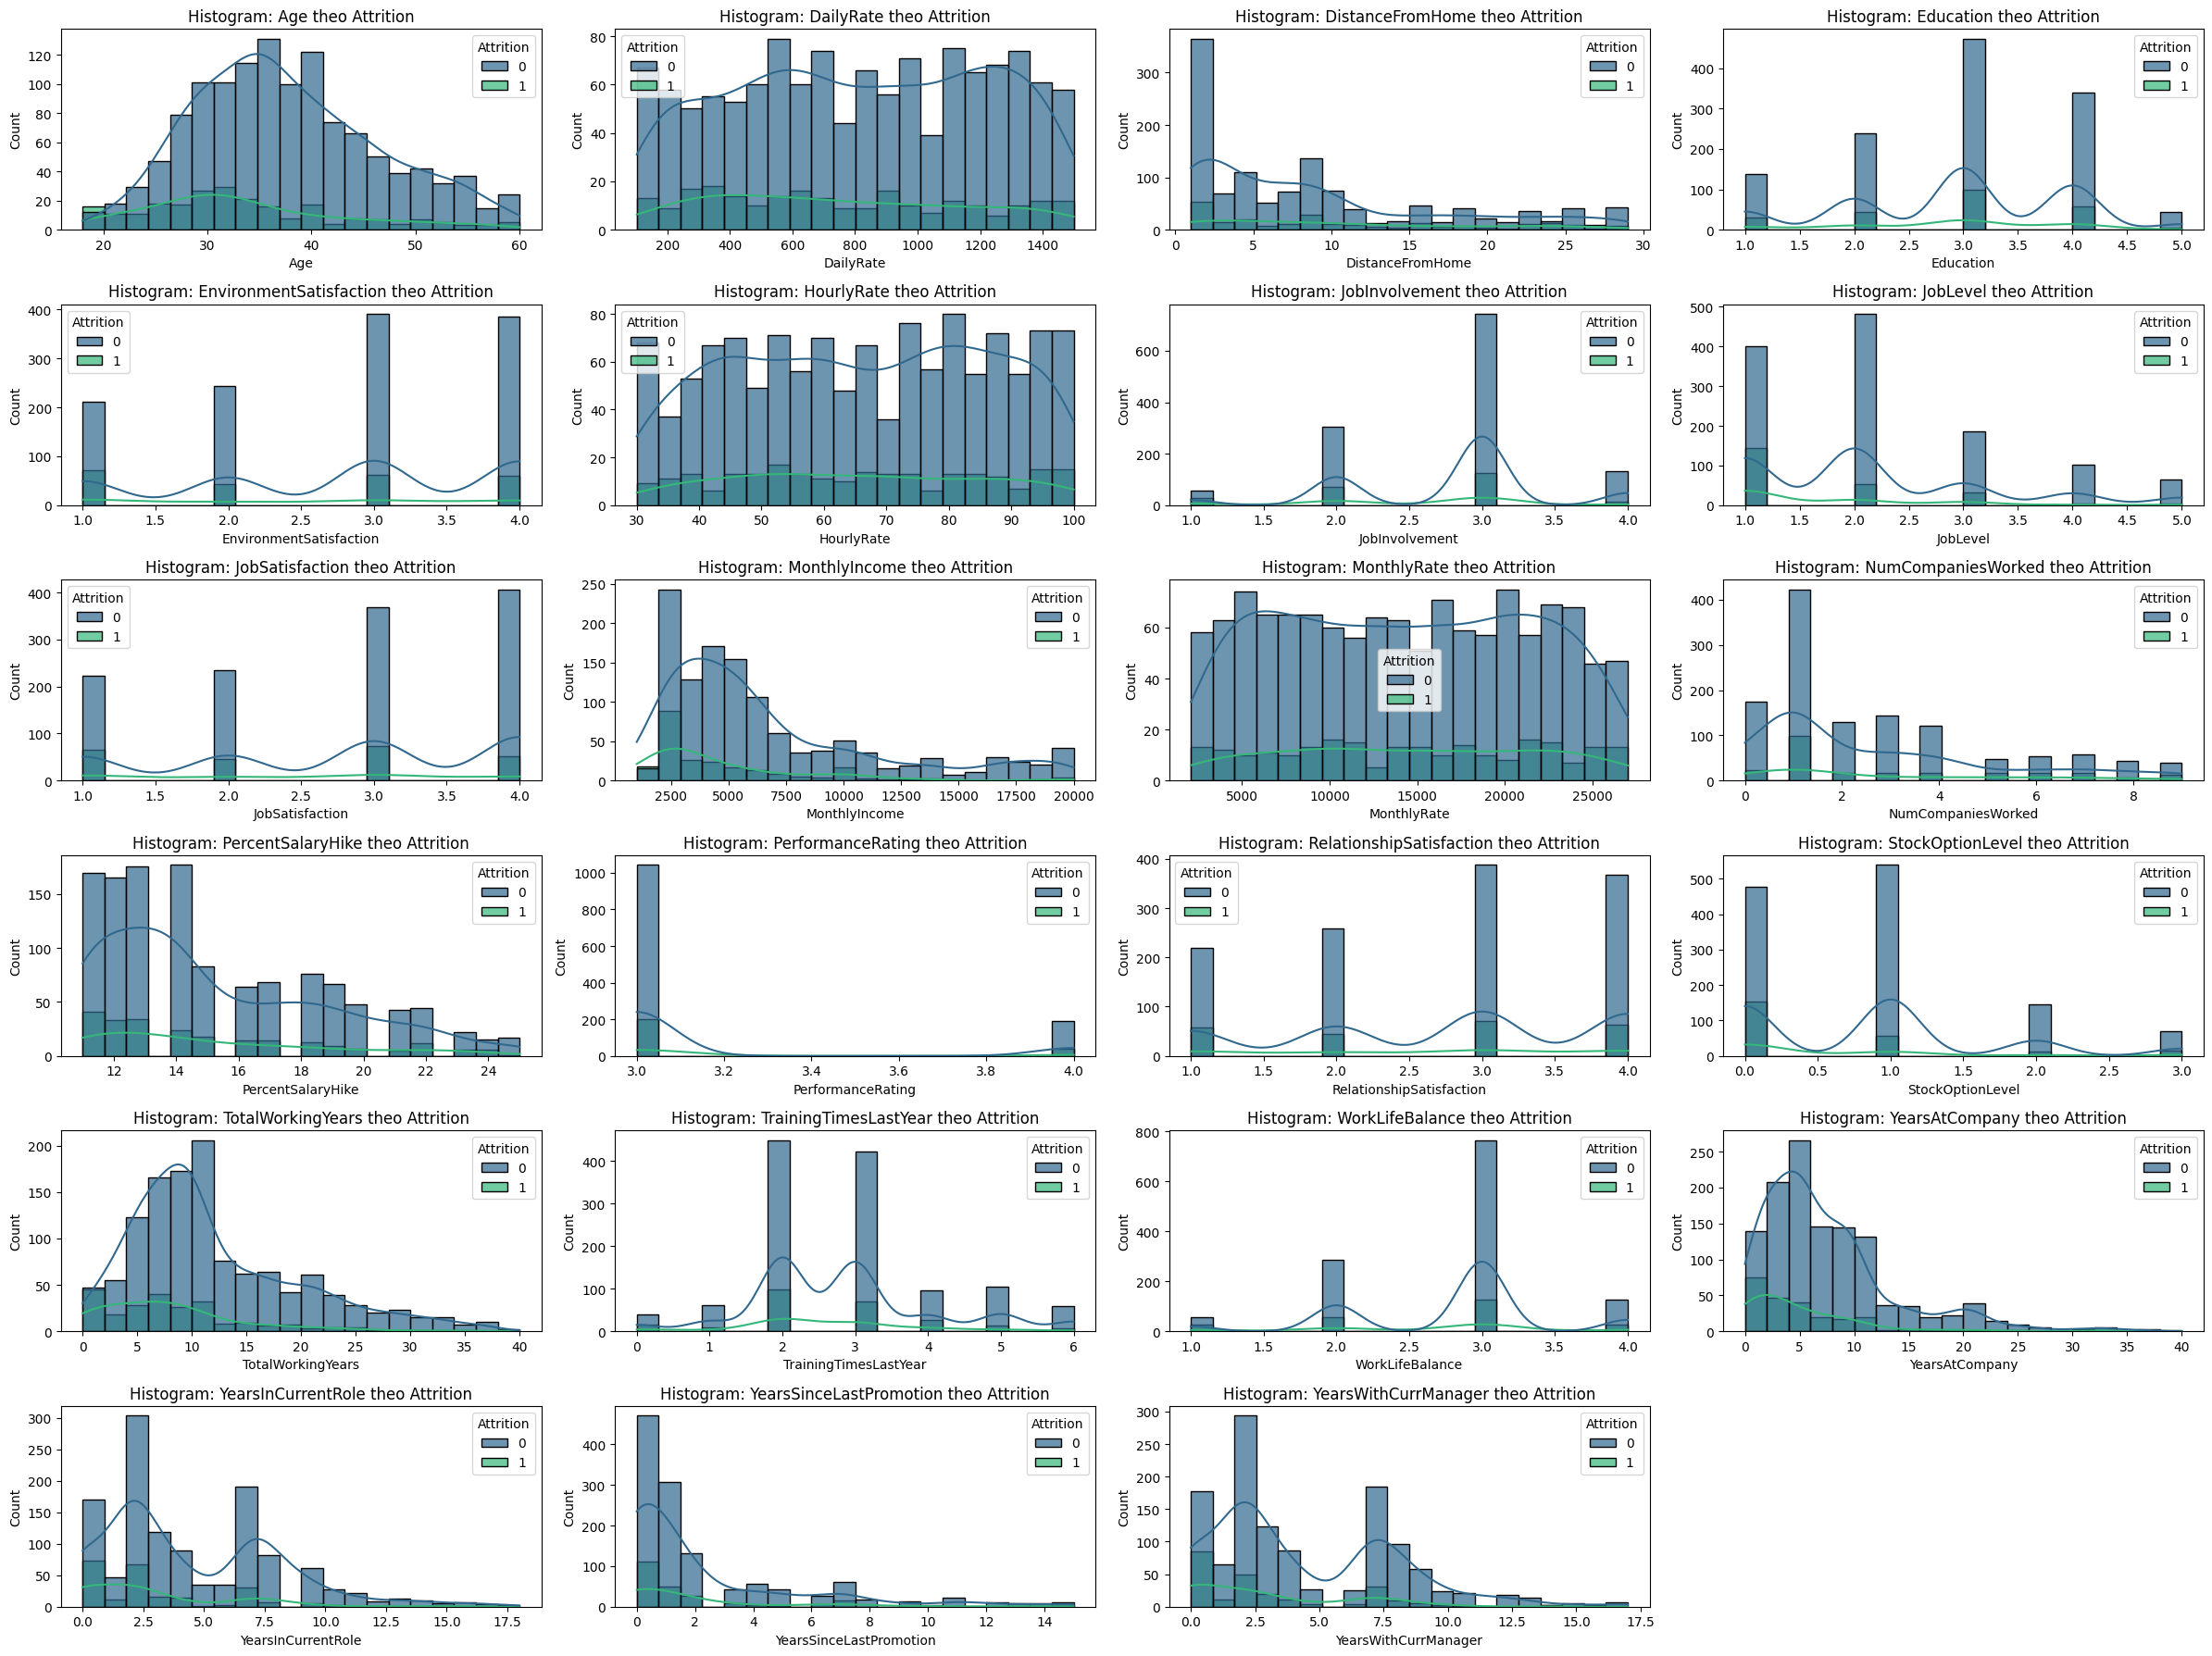

In [43]:
plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(data=df, x=col, hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
    plt.title(f'Histogram: {col} theo Attrition')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `BusinessTravel` for `x`. An entry with this name does not appear in `data`.

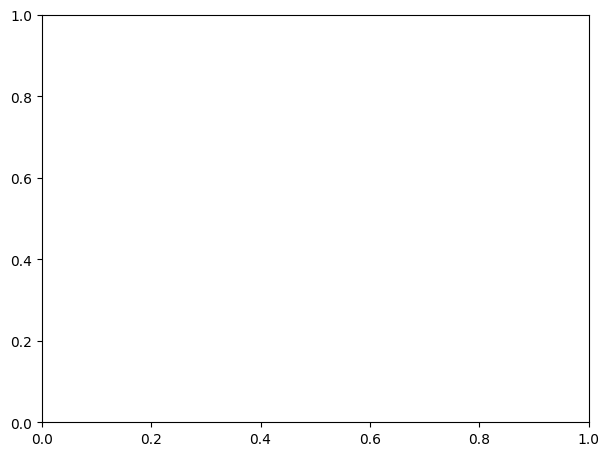

In [44]:
# Vẽ countplot giữa các biến phân loại và biến mục tiêu Attrition
plt.figure(figsize=(24, 18))
for idx, col in enumerate(categorical_cols):
    plt.subplot(3, 3, idx + 1)
    sns.countplot(data=df, x=col, hue='Attrition', palette='viridis')
    plt.title(f'Countplot: {col} vs Attrition')
    plt.xlabel(col)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

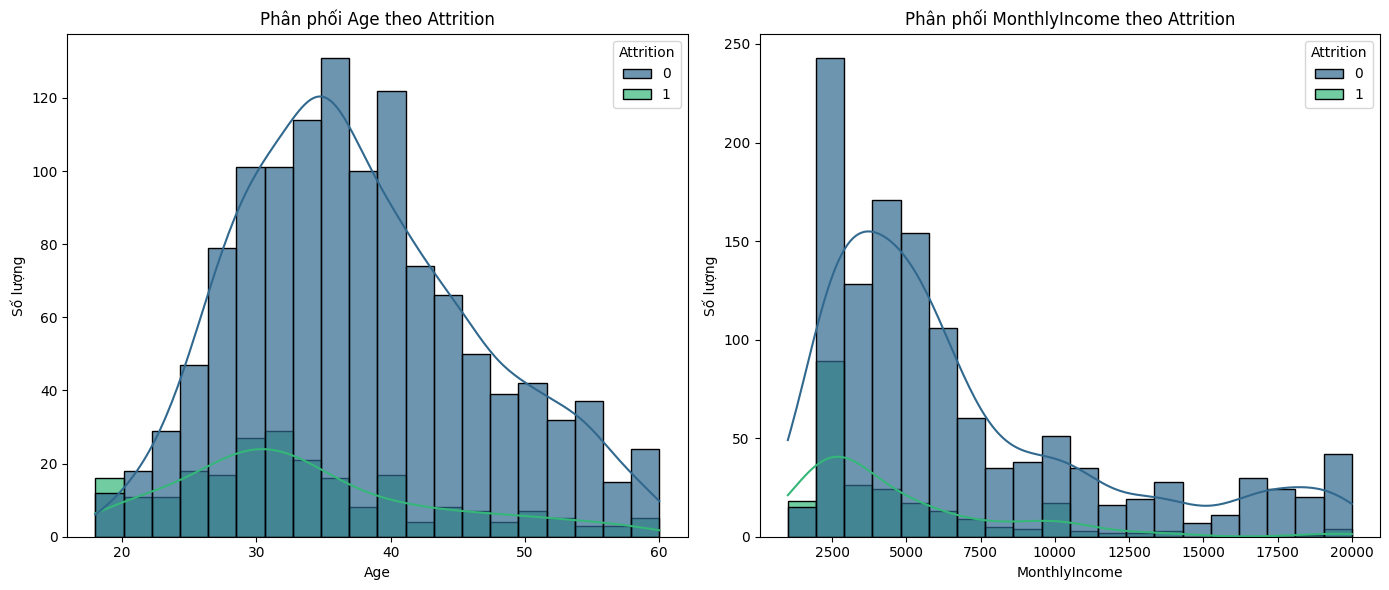

In [ ]:
plt.figure(figsize=(14, 6))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối Age theo Attrition')
plt.xlabel('Age')
plt.ylabel('Số lượng')

# Histogram for MonthlyIncome
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='MonthlyIncome', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối MonthlyIncome theo Attrition')
plt.xlabel('MonthlyIncome')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

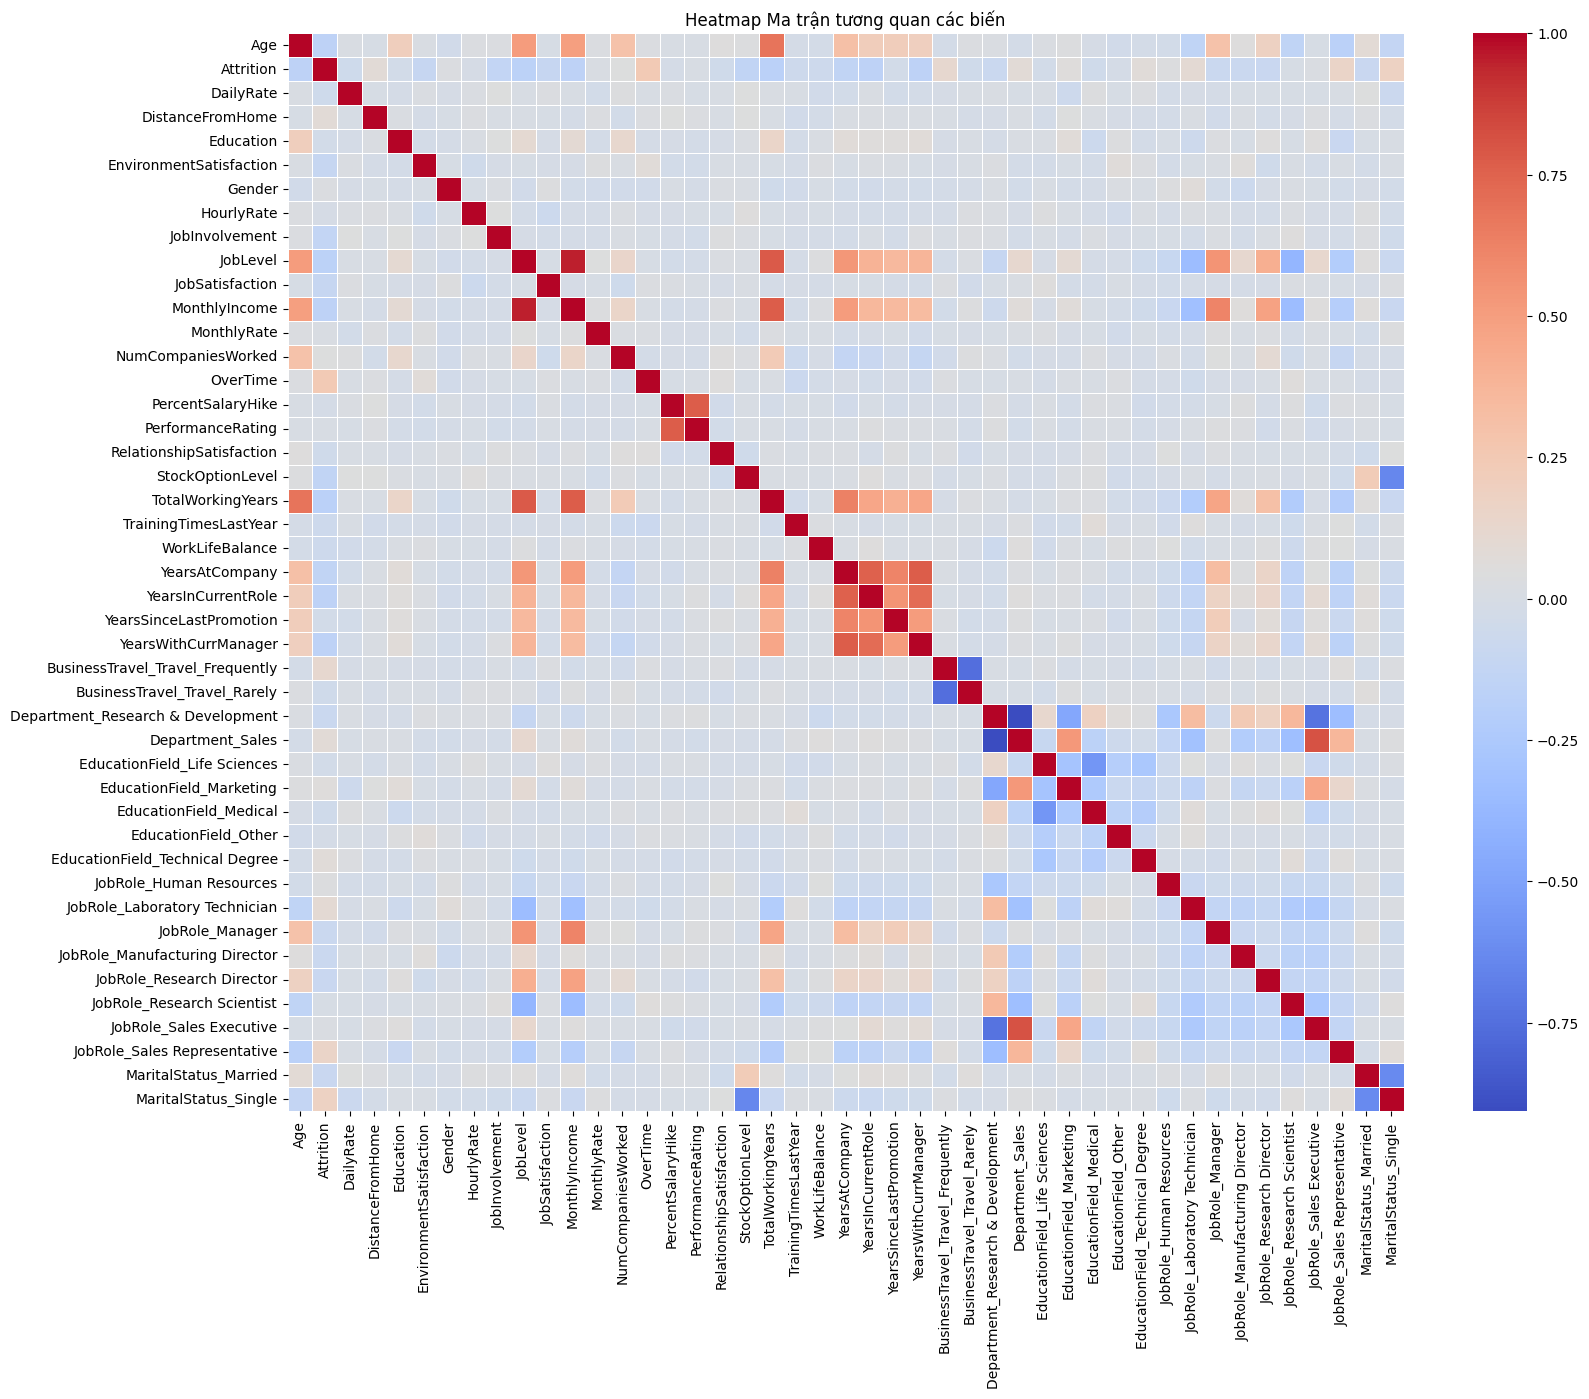

In [ ]:
# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap với seaborn
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Ma trận tương quan các biến')
plt.show()